# CNTK 201B: Hands On Labs Image Recognition

This hands-on lab shows how to implement image recognition task using convolution network with CNTK v2 Python API. You will start with a basic feedforward CNN architecture in order to classify Cifar dataset, then you will keep adding advance feature to your network. Finally, you will implement a residual nets similar to the one that won ImageNet competition but smaller in size.

## Introduction

In this hands-on, you will practice the following:

* Understanding subset of CNTK python primitive needed for image classification task.
* Write a custom convolution network to classify Cifar dataset.
* Modifying the network structure by adding:
 * Drop out layer.
 * Batchnormalization layer.
* Switching the above networks to CNTK layer API.
* Introduction to Residual Nets (RESNET).
* Implement and train RESNET network.


## Prerequisites

CNTK 201a hands-on lab, in which you will download and prepare Cifar dataset is a prerequisites for this lab. This tutorial depends on CNTK v2, so before starting this lab you will need to install CNTK v2. Furthermore, all the tutorials in this lab are done in python, therefore, you will need a basic knowledge of python.

CNTK 102 lab is recommended but not a prerequisites.

## Convolution Neural Network (CNN)

Convolution Neural Network (CNN) is a feedforward network comprise of a bunch of layers in such a way that the output of one layer is fed to the next layer (There are more complex architecture that skip layers, we will discuss one of those at the end of this lab). Usually, CNN start with alternating between convolution layer and pooling layer (downsample), then end up with fully connected layer for the classification part.

### Convolution layer

Convolution layer consist of multiple 2D convolution kernels applied on the input image or the previous layer, each convolution kernel output a feature map. 

<img src="https://github.com/Microsoft/CNTK/raw/master/bindings/python/tutorials/img/Conv2D.png">

The stack of feature maps output are the input to the next layer.

<img src="https://github.com/Microsoft/CNTK/raw/master/bindings/python/tutorials/img/Conv2DFeatures.png">

### Pooling layer

In most CNN vision architecture, each convolution layer is succeeded by a pooling layer, so they keep alternating until the fully connected layer. 

The purpose of the pooling layer is as follow:

* Reduce the dimensionality of the previous layer, which speed up the network.
* Provide a limited translation invariant.

Here an example of max pooling with a stride of 2:

<img src="https://github.com/Microsoft/CNTK/raw/master/bindings/python/tutorials/img/MaxPooling.png">

### Dropout layer

Dropout layer takes a probability value as an input, the value is called the dropout rate. Let's say the dropu rate is 0.5, what this layer does it pick at random 50% of the nodes from the previous layer and drop them out of the nework. This behavior help regularize the network.

### Batch normalization (BN)

Batch normalization is a way to make the input to each layer has zero mean and unit variance. BN help the network converge faster and keep the input of each layer around zero. BN has two learnable parameters called gamma and beta, the purpose of those parameters is for the network to decide for itself if the normalized input is what is best or the raw input.

## Computational Network Toolkit (CNTK)

CNTK is a highly flexible computation graphs, each node take inputs as tensors and produce tensors as the result of the computation. Each node is exposed in Python API, which give you the flexibility of creating any custom graphs, you can also define your own node in Python or C++ using CPU, GPU or both.

For Deep learning, you can use the low level API directly or you can use CNTK layered API. We will start with the low level API, then switch to the layered API in this lab.

So let's first import the needed modules for this lab.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
 
from cntk.blocks import *  # non-layer like building blocks such as LSTM()
from cntk.layers import *  # layer-like stuff
from cntk.models import *  # higher abstraction level, e.g. entire standard models and also operators like Sequential()
from cntk.utils import *
from cntk.io import MinibatchSource, ImageDeserializer, StreamDef, StreamDefs
from cntk.initializer import glorot_uniform
from cntk import Trainer
from cntk.learner import momentum_sgd, learning_rate_schedule
from cntk.ops import cross_entropy_with_softmax, classification_error, relu
from cntk.ops import convolution, pooling, PoolingType_Max, dropout

Now that we imported the needed modules, let's implement our first CNN, as shown below:

<img src="https://github.com/Microsoft/CNTK/raw/master/bindings/python/tutorials/img/CNN.png">

To implement the above, you will first implement each of the building blocks using CNTK low level python API.

In [6]:
def conv_layer(input, num_filters, filter_size, init, strides=(1,1), nonlinearity=relu):
    if nonlinearity is None:
        nonlinearity = lambda x: x

    channel_count = input.shape[0]

    b_param = parameter(shape=(num_filters, 1, 1))
    w_param = parameter(shape=(num_filters, channel_count, filter_size[0], filter_size[1]), init=init)
    r       = convolution(w_param, input, (channel_count, strides[0], strides[1])) + b_param
    r       = nonlinearity(r)

    return r

def bn_layer(input, spatial_rank, nonlinearity=relu, bn_time_const=5000, b_value=0, sc_value=1):
    if nonlinearity is None:
        nonlinearity = lambda x: x

    dims = input.shape[0]

    bias_params    = parameter((dims), init=b_value)
    scale_params   = parameter((dims), init=sc_value)
    running_mean   = constant(0, (dims))
    running_invstd = constant(0, (dims))

    r = batch_normalization(input, scale_params, bias_params, running_mean, running_invstd, spatial_rank > 0, bn_time_const, use_cudnn_engine=True)
    r = nonlinearity(r)
    return r

def conv_bn_layer(input, num_filters, filter_size, init, strides=(1,1), nonlinearity=relu, bn_time_const=5000, b_value=0, sc_value=1):
    r = conv_layer(input, num_filters, filter_size, init, strides=strides, nonlinearity=None)
    r = bn_layer(r, 2, nonlinearity=nonlinearity)
    return r

def dense_layer(input, num_units, init, nonlinearity=relu):
    if nonlinearity is None:
        nonlinearity = lambda x: x

    b_param = parameter(shape=(num_units))

    if len(input.shape) >= 3:
        w_param = parameter(shape=(input.shape[0], input.shape[1], input.shape[2], num_units), init=init)
    else:
        w_param = parameter(shape=(input.shape[0], num_units), init=init)

    r = b_param + times(input, w_param)
    r = nonlinearity(r)
    return r

def dense_bn_layer(input, num_units, init, nonlinearity=relu):
    r = dense_layer(input, num_units, init, nonlinearity=None)
    r = bn_layer(r, 0, nonlinearity=nonlinearity)
    return r

def max_pool_layer(input, pool_size, stride):
    return pooling(input, PoolingType_Max, (1, pool_size[0], pool_size[1]), (1, stride[0], stride[1]))

def dropout_layer(input, rate):
    return dropout(input, dropout_rate=rate)

So now that we defined the basic block for each layer, we can start defining our first CNN:

In [7]:
def create_basic_model(input, out_dims):
    net = {}

    net['conv1'] = conv_layer(input, 32, (5,5), init=glorot_uniform(scale=0.1557/256))
    net['pool1'] = max_pool_layer(net['conv1'], (3,3), (2,2))

    net['conv2'] = conv_layer(net['pool1'], 32, (5,5), init=glorot_uniform(scale=0.2))
    net['pool2'] = max_pool_layer(net['conv2'], (3,3), (2,2))

    net['conv3'] = conv_layer(net['pool2'], 64, (5,5), init=glorot_uniform(scale=0.2))
    net['pool3'] = max_pool_layer(net['conv3'], (3,3), (2,2))

    net['fc4']   = dense_layer(net['pool3'], 64, init=glorot_uniform(scale=1.697))
    net['fc5']   = dense_layer(net['fc4'], out_dims, init=glorot_uniform(scale=0.212), nonlinearity = None)

    return net

Before using the above model, we need to create a source reader in order to iterate through the labeled data.

In [8]:
# model dimensions
image_height = 32
image_width  = 32
num_channels = 3
num_classes  = 10

#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, mean_file, train):
    if not os.path.exists(map_file) or not os.path.exists(mean_file):
        cifar_py3 = "" if sys.version_info.major < 3 else "_py3"
        raise RuntimeError("File '%s' or '%s' does not exist. Please run CifarDownload%s.py and CifarConverter%s.py from CIFAR-10 to fetch them" %
                           (map_file, mean_file, cifar_py3, cifar_py3))

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    if train:
        transforms += [
            ImageDeserializer.crop(crop_type='Random', ratio=0.8, jitter_type='uniRatio') # train uses jitter
        ]
    transforms += [
        ImageDeserializer.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        ImageDeserializer.mean(mean_file)
    ]
    # deserializer
    return MinibatchSource(ImageDeserializer(map_file, StreamDefs(
        features = StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

Now let's write the the training and validation loop.

In [9]:
#
# Train and evaluate the network.
#
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):

    # Input variables denoting the features and label data
    input_var = input_variable((num_channels, image_height, image_width))
    label_var = input_variable((num_classes))

    # apply model to input
    model = model_func(input_var, out_dims=10)
    z = model['fc5']

    #
    # Training action
    #

    # loss and metric
    ce = cross_entropy_with_softmax(z, label_var)
    pe = classification_error(z, label_var)

    # training config
    epoch_size     = 50000
    minibatch_size = 64

    # For basic model
    lr_per_sample       = [0.00015625]*10+[0.000046875]*10+[0.0000156]
    momentum_per_sample = 0.9 ** (1.0 / minibatch_size)
    l2_reg_weight       = 0.03

    # For basic model with batch normalization
    # lr_per_sample       = [0.00046875]*7+[0.00015625]*10+[0.000046875]*10+[0.000015625]
    # momentum_per_sample = 0
    # l2_reg_weight       = 0

    # trainer object
    lr_schedule = learning_rate_schedule(lr_per_sample, units=epoch_size)
    learner     = momentum_sgd(z.parameters, lr_schedule, momentum_per_sample, 
                               l2_regularization_weight = l2_reg_weight)
    trainer     = Trainer(z, ce, pe, [learner])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    log_number_of_parameters(z) ; print()
    progress_printer = ProgressPrinter(tag='Training')

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            progress_printer.update_with_trainer(trainer, with_metric=True) # log progress
            batch_index += 1
        progress_printer.epoch_summary(with_metric=True)
        
    #
    # Evaluation action
    #
    epoch_size     = 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")
    
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()

Training 116906 parameters in 10 parameter tensors.

Finished Epoch [1]: [Training] loss = 1.856250 * 50000, metric = 68.5% * 50000
Finished Epoch [2]: [Training] loss = 1.480624 * 50000, metric = 53.3% * 50000
Finished Epoch [3]: [Training] loss = 1.319537 * 50000, metric = 46.7% * 50000
Finished Epoch [4]: [Training] loss = 1.219996 * 50000, metric = 42.6% * 50000
Finished Epoch [5]: [Training] loss = 1.140451 * 50000, metric = 39.6% * 50000

Final Results: Minibatch[1-626]: errs = 34.5% * 10000



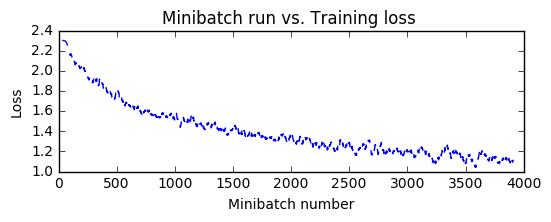

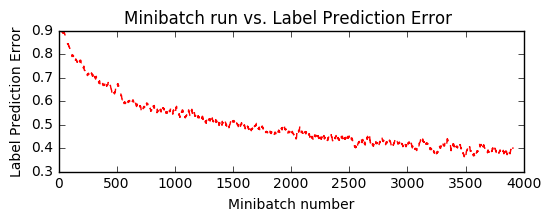

In [10]:
data_path = os.path.join('data', 'CIFAR-10')
reader_train = create_reader(os.path.join(data_path, 'train_map.txt'), os.path.join(data_path, 'CIFAR-10_mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'test_map.txt'), os.path.join(data_path, 'CIFAR-10_mean.xml'), False)

train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_basic_model)

Adding dropout layer before the last dense layer:

In [11]:
def create_basic_model_with_dropout(input, out_dims):
    net = {}

    net['conv1'] = conv_layer(input, 32, (5,5), init=glorot_uniform(scale=0.1557/256))
    net['pool1'] = max_pool_layer(net['conv1'], (3,3), (2,2))

    net['conv2'] = conv_layer(net['pool1'], 32, (5,5), init=glorot_uniform(scale=0.2))
    net['pool2'] = max_pool_layer(net['conv2'], (3,3), (2,2))

    net['conv3'] = conv_layer(net['pool2'], 64, (5,5), init=glorot_uniform(scale=0.2))
    net['pool3'] = max_pool_layer(net['conv3'], (3,3), (2,2))

    net['fc4']   = dense_layer(net['pool3'], 64, init=glorot_uniform(scale=1.697))
    net['drop4'] = dropout_layer(net['fc4'], 0.75)
    net['fc5']   = dense_layer(net['drop4'], out_dims, init=glorot_uniform(scale=0.212), nonlinearity=None)

    return net

Training 116906 parameters in 10 parameter tensors.

Finished Epoch [1]: [Training] loss = 2.084399 * 50000, metric = 79.4% * 50000
Finished Epoch [2]: [Training] loss = 1.852548 * 50000, metric = 70.2% * 50000
Finished Epoch [3]: [Training] loss = 1.758096 * 50000, metric = 65.7% * 50000
Finished Epoch [4]: [Training] loss = 1.682806 * 50000, metric = 63.1% * 50000
Finished Epoch [5]: [Training] loss = 1.634387 * 50000, metric = 60.7% * 50000

Final Results: Minibatch[1-626]: errs = 47.6% * 10000



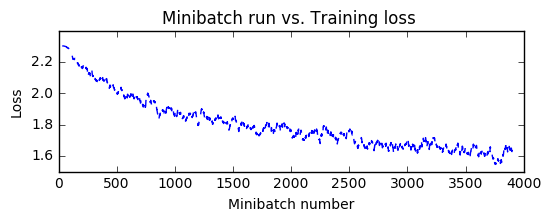

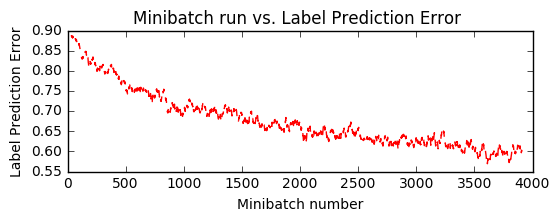

In [12]:
train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_basic_model_with_dropout)

Add batch normalization:

In [13]:
def create_basic_model_with_batch_normalization(input, out_dims):
    net = {}

    net['conv1'] = conv_bn_layer(input, 32, (5,5), init=glorot_uniform(scale=0.1557/256))
    net['pool1'] = max_pool_layer(net['conv1'], (3,3), (2,2))

    net['conv2'] = conv_bn_layer(net['pool1'], 32, (5,5), init=glorot_uniform(scale=0.2))
    net['pool2'] = max_pool_layer(net['conv2'], (3,3), (2,2))

    net['conv3'] = conv_bn_layer(net['pool2'], 64, (5,5), init=glorot_uniform(scale=0.2))
    net['pool3'] = max_pool_layer(net['conv3'], (3,3), (2,2))

    net['fc4']   = dense_bn_layer(net['pool3'], 64, init=glorot_uniform(scale=1.697))
    net['fc5']   = dense_layer(net['fc4'], out_dims, init=glorot_uniform(scale=0.212), nonlinearity=None)

    return net

Training 117290 parameters in 18 parameter tensors.

Finished Epoch [1]: [Training] loss = 1.676589 * 50000, metric = 58.5% * 50000
Finished Epoch [2]: [Training] loss = 1.377994 * 50000, metric = 48.9% * 50000
Finished Epoch [3]: [Training] loss = 1.242255 * 50000, metric = 44.1% * 50000
Finished Epoch [4]: [Training] loss = 1.151300 * 50000, metric = 40.4% * 50000
Finished Epoch [5]: [Training] loss = 1.080074 * 50000, metric = 37.9% * 50000

Final Results: Minibatch[1-626]: errs = 37.5% * 10000



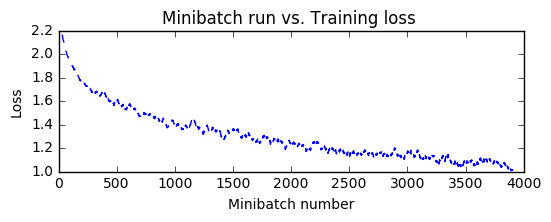

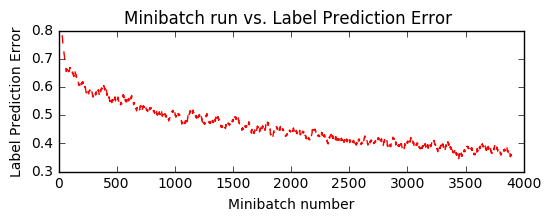

In [14]:
train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_basic_model_with_batch_normalization)

CNTK high layer API:

In [15]:
def create_basic_model_layer(input, out_dims):
    net = {}

    net['conv1'] = Convolution((5,5), 32, init=glorot_uniform(scale=0.1557/256), activation=relu, pad=True)(input)
    net['pool1'] = MaxPooling((3,3), strides=(2,2))(net['conv1'])

    net['conv2'] = Convolution((5,5), 32, init=glorot_uniform(scale=0.2), activation=relu, pad=True)(net['pool1'])
    net['pool2'] = MaxPooling((3,3), strides=(2,2))(net['conv2'])

    net['conv3'] = Convolution((5,5), 32, init=glorot_uniform(scale=0.2), activation=relu, pad=True)(net['pool2'])
    net['pool3'] = MaxPooling((3,3), strides=(2,2))(net['conv3'])
    

    net['fc4']   = Dense(64, init=glorot_uniform(scale=1.697))(net['pool3'])
    net['fc5']   = Dense(out_dims, init=glorot_uniform(scale=0.212), activation=None)(net['fc4'])
    
    return net

Training 72842 parameters in 10 parameter tensors.

Finished Epoch [1]: [Training] loss = 1.784447 * 50000, metric = 65.3% * 50000
Finished Epoch [2]: [Training] loss = 1.440226 * 50000, metric = 51.5% * 50000
Finished Epoch [3]: [Training] loss = 1.305892 * 50000, metric = 46.0% * 50000
Finished Epoch [4]: [Training] loss = 1.218082 * 50000, metric = 42.8% * 50000
Finished Epoch [5]: [Training] loss = 1.167807 * 50000, metric = 40.6% * 50000

Final Results: Minibatch[1-626]: errs = 42.3% * 10000



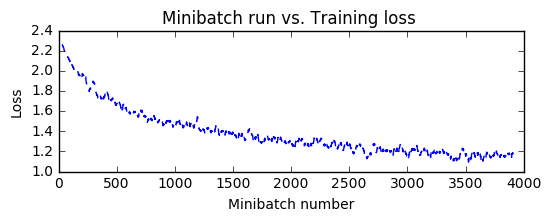

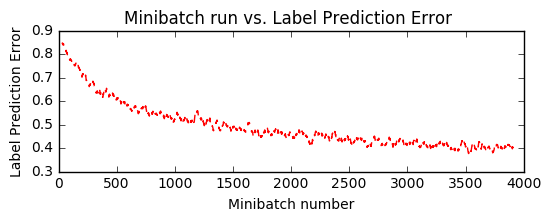

In [16]:
train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_basic_model_layer)

Too much code, let's make it terse:

In [17]:
def create_basic_model_layer_terse(input, out_dims):
    net = {}

    with default_options(activation=relu):
        model = Sequential([
            LayerStack(3, lambda i: [
                Convolution((5,5), [32,32,64][i], init=glorot_uniform(scale=[0.1557/256,0.2,0.2][i]), pad=True),
                MaxPooling((3,3), strides=(2,2))
            ]),
            Dense(64, init=glorot_uniform(scale=1.697)),
            Dense(out_dims, init=glorot_uniform(scale=0.212), activation=None)
        ])

    net['fc5'] = model(input)

    return net


Training 116906 parameters in 10 parameter tensors.

Finished Epoch [1]: [Training] loss = 1.802772 * 50000, metric = 65.5% * 50000
Finished Epoch [2]: [Training] loss = 1.446905 * 50000, metric = 51.5% * 50000
Finished Epoch [3]: [Training] loss = 1.298573 * 50000, metric = 45.7% * 50000
Finished Epoch [4]: [Training] loss = 1.195180 * 50000, metric = 41.7% * 50000
Finished Epoch [5]: [Training] loss = 1.126333 * 50000, metric = 38.8% * 50000

Final Results: Minibatch[1-626]: errs = 37.0% * 10000



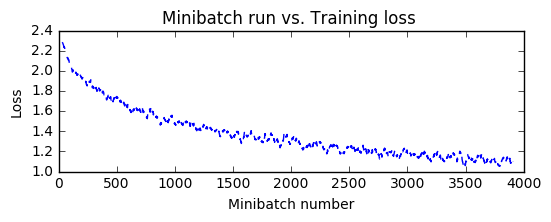

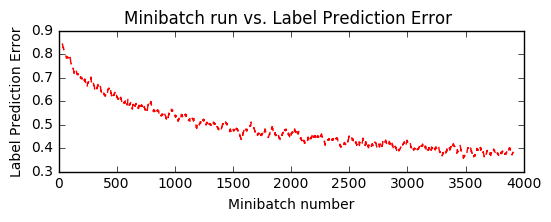

In [18]:
train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_basic_model_layer_terse)

Let's implement an inspired VGG style network, using layer API, here the architecture:

| VGG9          |
| ------------- |
| conv3-64      |
| conv3-64      |
| max3          |
|               |
| conv3-96      |
| conv3-96      |
| max3          |
|               |
| conv3-128     |
| conv3-128     |
| max3          |
|               |
| FC-1024       |
| dropout0.5    |
|               |
| FC-1024       |
| dropout0.5    |
|               |
| FC-10         |


In [19]:
def create_vgg9_model(input, out_dims):
    net = {}
    with default_options(activation=relu):
        model = Sequential([
            LayerStack(3, lambda i: [
                Convolution((3,3), [64,96,128][i], pad=True),
                Convolution((3,3), [64,96,128][i], pad=True),
                MaxPooling((3,3), strides=(2,2))
            ]),
            LayerStack(2, lambda : [
                Dense(1024),
                Dropout(0.5)
            ]),
            Dense(out_dims, activation=None)
        ])
    net['fc5'] = model(input)
    return net

Training 2675978 parameters in 18 parameter tensors.

Finished Epoch [1]: [Training] loss = 1.951907 * 50000, metric = 72.7% * 50000
Finished Epoch [2]: [Training] loss = 1.616987 * 50000, metric = 59.6% * 50000
Finished Epoch [3]: [Training] loss = 1.431715 * 50000, metric = 51.7% * 50000
Finished Epoch [4]: [Training] loss = 1.292608 * 50000, metric = 46.0% * 50000
Finished Epoch [5]: [Training] loss = 1.172547 * 50000, metric = 41.7% * 50000

Final Results: Minibatch[1-626]: errs = 35.0% * 10000



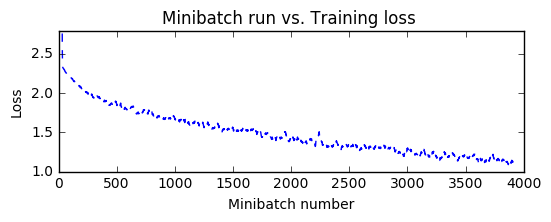

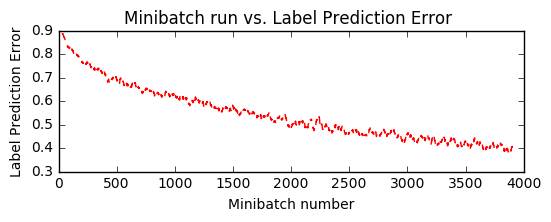

In [20]:
train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_vgg9_model)

### Residual Network (ResNet)

One of the main problem of a Deep Neural Network is how to propagate the error all the way to the first layer. For a deep network, the gradient keep getting smaller until it has no effect on the network weights. [ResNet](https://arxiv.org/abs/1512.03385) was designed to overcome such problem, by defining a block with identity path, as shown below:

<img src="https://github.com/Microsoft/CNTK/raw/master/bindings/python/tutorials/img/ResNetBlock2.png">

The idea of the above block is 2 folds:

* During back propagation the gradient have a path that doesn't affect its magnitude.
* The network need to learn residual mapping (delta to x).

So let's implements ResNet blocks using CNTK:

            ResNetNode                   ResNetNodeInc
                |                              |
         +------+------+             +---------+----------+
         |             |             |                    |
         V             |             V                    V
    +----------+       |      +--------------+   +----------------+
    | Conv, BN |       |      | Conv x 2, BN |   | SubSample, BN  |
    +----------+       |      +--------------+   +----------------+
         |             |             |                    |
         V             |             V                    |
     +-------+         |         +-------+                |
     | ReLU  |         |         | ReLU  |                |
     +-------+         |         +-------+                |
         |             |             |                    |
         V             |             V                    |
    +----------+       |        +----------+              |
    | Conv, BN |       |        | Conv, BN |              |
    +----------+       |        +----------+              |
         |             |             |                    |
         |    +---+    |             |       +---+        |
         +--->| + |<---+             +------>+ + +<-------+
              +---+                          +---+
                |                              |
                V                              V
            +-------+                      +-------+
            | ReLU  |                      | ReLU  |
            +-------+                      +-------+
                |                              |
                V                              V


In [21]:
from cntk.ops import combine, times, element_times, AVG_POOLING

def resnet_basic(input, num_filters):
    c1 = conv_bn_layer(input, num_filters, (3,3), init=glorot_uniform())
    c2 = conv_bn_layer(c1, num_filters, (3,3), init=glorot_uniform(), nonlinearity=None)
    p  = c2 + input
    return relu(p)

def resnet_basic_inc(input, num_filters):
    c1 = conv_bn_layer(input, num_filters, (3,3), strides=(2,2), init=glorot_uniform())
    c2 = conv_bn_layer(c1, num_filters, (3,3), init=glorot_uniform(), nonlinearity=None)    
    s  = conv_bn_layer(input, num_filters, (1,1), strides=(2,2), init=glorot_uniform(), nonlinearity=None)
    
    p = c2 + s
    return relu(p)

def resnet_basic_stack2(input, num_filters):
    r1 = resnet_basic(input, num_filters)
    r2 = resnet_basic(r1, num_filters)
    return r2

def resnet_basic_stack3(input, num_filters):
    r12 = resnet_basic_stack2(input, num_filters)
    r3 = resnet_basic(r12, num_filters)
    return r3


Let's write the full model:

In [22]:
def create_resnet_model(input, out_dims):
    net = {}
    feat_scale = 1.0 / 256.0
    input_norm = element_times(feat_scale, input)

    conv = conv_bn_layer(input, 16, (3,3), init=glorot_uniform(), nonlinearity=None)
    r1_1 = resnet_basic_stack3(conv, 16)

    r2_1 = resnet_basic_inc(r1_1, 32)
    r2_2 = resnet_basic_stack2(r2_1, 32)

    r3_1 = resnet_basic_inc(r2_2, 64)
    r3_2 = resnet_basic_stack2(r3_1, 64)

    # Global average pooling
    poolw = 8
    poolh = 8
    poolh_stride = 1
    poolv_stride = 1

    pool = pooling(r3_2, AVG_POOLING, (1, poolh, poolw), (1, poolv_stride, poolh_stride))
    net['fc5'] = dense_layer(pool, out_dims, init=glorot_uniform(), nonlinearity=None)
    
    return net

Training 273258 parameters in 86 parameter tensors.

Finished Epoch [1]: [Training] loss = 1.517275 * 50000, metric = 55.6% * 50000
Finished Epoch [2]: [Training] loss = 1.139407 * 50000, metric = 40.9% * 50000
Finished Epoch [3]: [Training] loss = 0.963979 * 50000, metric = 34.1% * 50000
Finished Epoch [4]: [Training] loss = 0.856386 * 50000, metric = 30.2% * 50000
Finished Epoch [5]: [Training] loss = 0.777330 * 50000, metric = 27.2% * 50000

Final Results: Minibatch[1-626]: errs = 36.0% * 10000



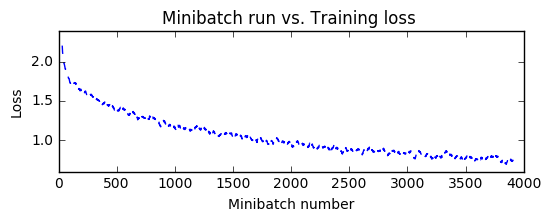

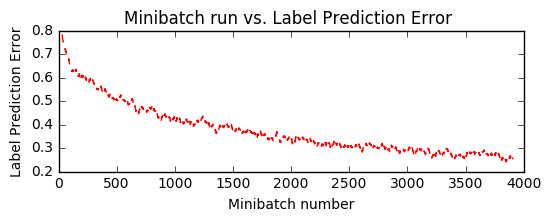

In [23]:
train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_resnet_model)